In [223]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn import ensemble
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

#!pip install --upgrade sklearn
#!pip install --upgrade scikit-learn

In [224]:
df = pd.read_csv('raw_data/KaggleV2-May-2016.csv')

In [225]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [226]:
#check in every appointment id is unique
len(df.AppointmentID.value_counts()) == len(df)

True

In [227]:
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [228]:
#convert dates to datetime format getting rid of the hour

from datetime import datetime

df.ScheduledDay = pd.to_datetime(df.ScheduledDay)
df.ScheduledDay = df.ScheduledDay.apply(lambda x: x.floor('D'))
df.AppointmentDay = pd.to_datetime(df.AppointmentDay)
df.AppointmentDay = df.AppointmentDay.apply(lambda x: x.floor('D'))

In [229]:
#convert gender to numerical values
df['Gender'] = df['Gender'].replace('F', 0)
df['Gender'] = df['Gender'].replace('M', 1)

In [230]:
#check if the conversion went right
df['Gender'].unique()

array([0, 1])

In [231]:
df['No-show'] = df['No-show'].replace('Yes', 1)
df['No-show'] = df['No-show'].replace('No', 0)

In [232]:
#create column containing how many number of days in advance the applointment was scheduled
df['days_in_advance'] =  df.AppointmentDay - df.ScheduledDay
df['days_in_advance'] = df['days_in_advance'].apply(lambda x: x.days)

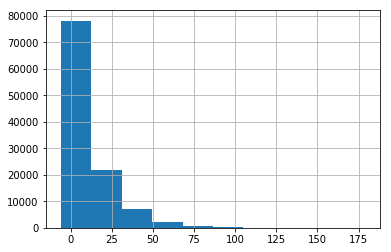

In [233]:
df['days_in_advance'].hist();

In [234]:
#check where the values for days_in_advance are negative: drop these rows
df = df.drop(df[df['days_in_advance'] < 0].index)

In [235]:
df = df.reset_index(drop=True)

In [236]:
#check if it worked: YES
#df['days_in_advance'] < 0

In [237]:
#create column with month of the appointment


df['appointment_month'] =  df.AppointmentDay.apply(lambda x: x.month)

In [238]:
df['appointment_month'].unique()

array([4, 5, 6])

In [239]:
#create column with day of the week of the appointment

df['appointment_day_of_the_week'] =  df.AppointmentDay.apply(lambda x: x.weekday())

In [240]:
df['appointment_day_of_the_week'].unique()

array([4, 1, 0, 2, 3, 5])

## One hot encoding

In [241]:
#create binary values for appointment_month

In [242]:
from sklearn.preprocessing import OneHotEncoder

In [243]:
month_category = df["appointment_month"].values.reshape(-1, 1)

In [244]:
encoder = OneHotEncoder(drop='first', categories='auto').fit(month_category)

In [245]:
encoder.categories_

[array([4, 5, 6])]

In [246]:
encoder.get_feature_names(["month_appointment"])

array(['month_appointment_5', 'month_appointment_6'], dtype=object)

In [247]:
ohe = pd.DataFrame(encoder.transform(month_category).toarray(),
                   columns=encoder.get_feature_names(["month_appointment"]))

In [248]:
ohe.columns

Index(['month_appointment_5', 'month_appointment_6'], dtype='object')

In [249]:
df = df.drop(["appointment_month"], axis=1)

In [250]:
df = pd.concat([df, ohe], axis=1, join='inner')

In [251]:
#create categories for appointment_day_of_week

day_of_week_category = df["appointment_day_of_the_week"].values.reshape(-1, 1)

In [252]:
df["appointment_day_of_the_week"].unique()

array([4, 1, 0, 2, 3, 5])

In [253]:
encoder = OneHotEncoder(drop='first', categories='auto').fit(day_of_week_category)

In [254]:
encoder.categories_

[array([0, 1, 2, 3, 4, 5])]

In [255]:
encoder.get_feature_names(["day_of_week_appointment"])

array(['day_of_week_appointment_1', 'day_of_week_appointment_2',
       'day_of_week_appointment_3', 'day_of_week_appointment_4',
       'day_of_week_appointment_5'], dtype=object)

In [256]:
ohe = pd.DataFrame(encoder.transform(day_of_week_category).toarray(),
                   columns=encoder.get_feature_names(["day_of_week_appointment"]))

In [257]:
df = pd.concat([df.drop("appointment_day_of_the_week", axis=1), ohe], axis=1, join='inner')

In [258]:
#df.tail()

## Create 2 more features: number of previous appointments, number of previous no-shows

In [259]:
def get_num_apptmnts_noshows(patient_id, df):
    '''Returns a list of dictionaries with numbers of previous apointments and number
    of previous no-shows for each appintment id'''
    
    df_subset = df[df['PatientId'] == patient_id]
    df_subset = df_subset.sort_values(by='AppointmentDay')
    df_subset = df_subset.reset_index()
    df_subset['number_of_previous_apptms'] = df_subset.index
    
    no_shows = []
    for i in df_subset.index:
        if i == 0:
            no_shows.append(0)
        else:
            df_slice = df_subset.iloc[0:i, :]
            no_shows.append(sum(df_slice['No-show']))
            
    df_subset['number_of_previous_noshows'] = no_shows
    
    subset_dict = df_subset[['AppointmentID', 'number_of_previous_apptms', 'number_of_previous_noshows']].to_dict(orient='index')
        
    return subset_dict



In [260]:
def update_dataframe(df):
    '''Updates dataframe with values for columns number_of_previous_apptms, number_of_previous_noshows'''
    
    #create an array with unique patient ids
    patient_ids = np.unique(df['PatientId'].values)
    
    #get values for previous appointment numbers and previous no-shows
    dict_values = []
    
    counter = 0
    
    
    
    for pid in patient_ids:
        
        if (counter % 500) == 0:
            print("main loop state: ", counter)
            
        dict_values.append(get_num_apptmnts_noshows(pid, df))
        counter += 1
        
    #fill df with nan numbers
    df['number_of_previous_apptms'] = np.nan
    df['number_of_previous_noshows'] = np.nan
    
    counter_2 = 0
    
    
    
    #update the dataframe
    for d in dict_values:
        for v in d.values():
            
            if (counter_2 % 500) == 0:
                print("inner loop state: ", counter_2)
                
            selected_row = df[df['AppointmentID'] == v['AppointmentID']]
            index = selected_row.index
            df.loc[index, 'number_of_previous_apptms'] = v['number_of_previous_apptms']
            df.loc[index, 'number_of_previous_noshows'] = v['number_of_previous_noshows']
            counter_2 += 1
    return df

In [261]:
#test a slice of a dataset
#df_test = update_dataframe(df[201:1000])

In [262]:
#df_test

In [263]:
#test
#df[df['PatientId'] == 476946211846992.0]

In [264]:
#df_test.head()

In [265]:
#patient id to test
#df_test[df_test['PatientId'] == 476946211846992.0]

## Test train split

In [266]:
from sklearn.model_selection import train_test_split

In [267]:
# sort dataframe by appointment date to perform time series split: 
# we should split according to how recent the data is instead of just a random split

In [268]:
df = df.sort_values(by='AppointmentDay')

In [269]:
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,...,SMS_received,No-show,days_in_advance,month_appointment_5,month_appointment_6,day_of_week_appointment_1,day_of_week_appointment_2,day_of_week_appointment_3,day_of_week_appointment_4,day_of_week_appointment_5
0,2.987250e+13,5642903,0,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2151,7.257760e+11,5521232,1,2016-03-29,2016-04-29,33,MARIA ORTIZ,0,0,0,...,1,0,31,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2152,9.475572e+13,5521230,0,2016-03-29,2016-04-29,50,MARIA ORTIZ,0,0,0,...,0,0,31,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2153,3.538755e+13,5523393,0,2016-03-29,2016-04-29,69,MARIA ORTIZ,0,0,0,...,1,0,31,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2154,7.324990e+14,5642808,0,2016-04-29,2016-04-29,65,MARIA ORTIZ,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [270]:
y = df['No-show']
X = df

#to maintain time order of the appointment date, shuffle is set to False
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

In [271]:
y.value_counts()

0    88208
1    22314
Name: No-show, dtype: int64

#### We got X_test_new and X_train new by applying the above function. The results were saved as csv file.

In [272]:
#X_test_new saved to csv file, no need to run this again
#X_test_new = update_dataframe(X_test)

In [273]:
#X_test_new.to_csv('X_test_new.csv')

In [274]:
#X_test_new.to_csv('X_test_new_no_index.csv', index=False)

In [275]:
#dataframe saved to csv, no need to run it

#X_train_new = update_dataframe(X_train)

In [276]:
#X_test_new.to_csv('X_test_new_no_index.csv', index=False)

In [277]:
#X_train_new.to_csv('X_train_new.csv')
#X_train_new.to_csv('X_train_new_no_index.csv', index=False)

In [278]:
#save y_test and y_train

In [279]:
#y_train.to_csv('y_train.csv')
#y_train.to_csv('y_train_no_index.csv', index=False)

#y_test.to_csv('y_test.csv')
#y_test.to_csv('y_test_no_index.csv', index=False)

#### Retrieving data from csv

In [280]:
X_train_new = pd.read_csv('X_train_new.csv', index_col=0)
X_test_new = pd.read_csv('X_test_new.csv', index_col=0)
y_train = pd.read_csv('y_train.csv', header=None, index_col=0)
y_test = pd.read_csv('y_test.csv', header=None, index_col=0)

In [281]:
len(X_train_new) == len(y_train)

True

In [282]:
len(X_test_new) == len(y_test)

True

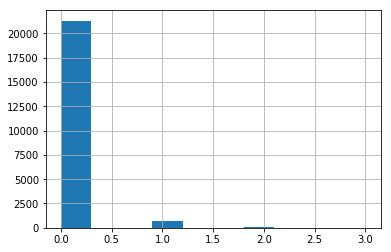

In [283]:
X_test_new['number_of_previous_noshows'].hist();

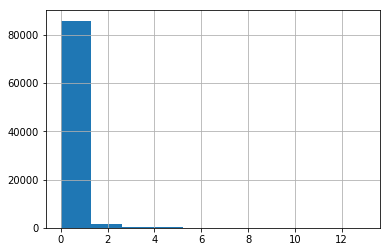

In [284]:
X_train_new['number_of_previous_noshows'].hist();

## Doublecheck correlation before applying classification models

In [285]:
X_train_new.corr()

,PatientId,AppointmentID,Gender,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,...,days_in_advance,month_appointment_5,month_appointment_6,day_of_week_appointment_1,day_of_week_appointment_2,day_of_week_appointment_3,day_of_week_appointment_4,day_of_week_appointment_5,number_of_previous_apptms,number_of_previous_noshows
PatientId,1.000000,0.003465,0.008613,-0.002170,-0.001574,-0.002534,0.001664,0.011537,-0.008082,-0.010508,...,-0.000827,0.000404,-0.000067,0.002524,-0.002873,-0.004159,0.002759,-0.005519,0.017249,0.001462
AppointmentID,0.003465,1.000000,0.023706,-0.025672,0.026919,0.013053,0.024921,0.034725,0.015615,-0.316046,...,-0.836146,-0.030617,0.208185,0.070257,0.109609,-0.041674,-0.116663,0.006571,0.176047,0.119974
Gender,0.008613,0.023706,1.000000,-0.106640,-0.117978,-0.056664,-0.035967,0.107410,0.021890,-0.044995,...,-0.029420,-0.000736,-0.001622,-0.008629,-0.001556,0.001369,0.004190,-0.004176,0.079053,0.011599
Age,-0.002170,-0.025672,-0.106640,1.000000,-0.090518,0.505453,0.292012,0.097248,0.080938,0.013416,...,0.038627,-0.000942,0.010642,0.008837,0.000059,-0.001294,-0.006330,0.015116,0.051612,-0.012958
Scholarship,-0.001574,0.026919,-0.117978,-0.090518,1.000000,-0.017225,-0.023446,0.033061,-0.008340,0.004539,...,-0.032098,0.000915,-0.001345,0.005042,-0.002739,-0.001711,0.000656,-0.001530,0.005384,0.037535
Hipertension,-0.002534,0.013053,-0.056664,0.505453,-0.017225,1.000000,0.432453,0.091636,0.083056,-0.004178,...,-0.018140,0.001764,0.000213,0.005593,-0.004281,0.002246,-0.004323,0.015360,-0.005260,-0.004271
Diabetes,0.001664,0.024921,-0.035967,0.292012,-0.023446,0.432453,1.000000,0.020094,0.059680,-0.012454,...,-0.029856,-0.003803,0.002843,0.002179,-0.001662,-0.005068,0.006461,0.008827,-0.017411,-0.002728
Alcoholism,0.011537,0.034725,0.107410,0.097248,0.033061,0.091636,0.020094,1.000000,0.003654,-0.024171,...,-0.040252,-0.002318,0.001149,-0.002960,-0.002555,-0.003512,0.003816,0.002625,0.156572,0.012361
Handcap,-0.008082,0.015615,0.021890,0.080938,-0.008340,0.083056,0.059680,0.003654,1.000000,-0.023413,...,-0.020069,0.000521,-0.001273,0.001915,-0.003829,0.004455,0.003184,0.000434,0.008587,0.021657
SMS_received,-0.010508,-0.316046,-0.044995,0.013416,0.004539,-0.004178,-0.012454,-0.024171,-0.023413,1.000000,...,0.368586,-0.064953,0.045921,0.121821,0.045241,-0.042355,-0.113832,0.001931,-0.063203,-0.032477


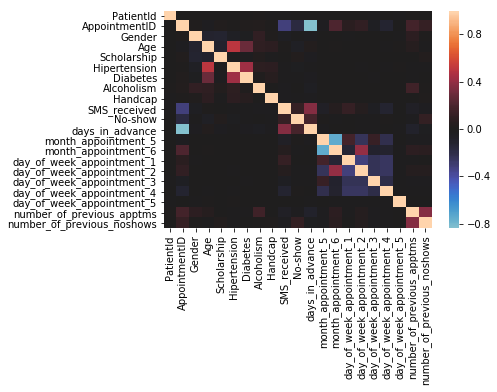

In [286]:
import seaborn as sns
sns.heatmap(X_train_new.corr(), center=0);

## Drop non-numeric features: neibourhoods, dates

In [287]:
X_train_new.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,...,days_in_advance,month_appointment_5,month_appointment_6,day_of_week_appointment_1,day_of_week_appointment_2,day_of_week_appointment_3,day_of_week_appointment_4,day_of_week_appointment_5,number_of_previous_apptms,number_of_previous_noshows
0,2.987250e+13,5642903,0,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,...,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2151,7.257760e+11,5521232,1,2016-03-29,2016-04-29,33,MARIA ORTIZ,0,0,0,...,31,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2152,9.475572e+13,5521230,0,2016-03-29,2016-04-29,50,MARIA ORTIZ,0,0,0,...,31,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2153,3.538755e+13,5523393,0,2016-03-29,2016-04-29,69,MARIA ORTIZ,0,0,0,...,31,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2154,7.324990e+14,5642808,0,2016-04-29,2016-04-29,65,MARIA ORTIZ,0,0,0,...,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [288]:
#drop columns
X_train_new  = X_train_new.drop(['Neighbourhood', 'ScheduledDay', 'AppointmentDay', 'PatientId', 'AppointmentID', 'No-show'], axis=1)
X_test_new = X_test_new.drop(['Neighbourhood', 'AppointmentDay', 'ScheduledDay', 'PatientId', 'AppointmentID', 'No-show'], axis=1)


## SMOTE to correct class imbalance

The ratio on no-shows and shows is very unbalances which can affect model performance. We should correct the imbalance creating equal samples to compensate for lack of no-show data

In [289]:
#!pip install imblearn

In [290]:
from imblearn.over_sampling import SMOTE

In [291]:
smt = SMOTE()
X_train_new, y_train = smt.fit_resample(X_train_new, y_train) 

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [292]:
test_imbalance_df = pd.DataFrame(y_train)

In [293]:
test_imbalance_df.head()

,0
0,0
1,0
2,0
3,0
4,0


In [294]:
test_imbalance_df[0].value_counts()

1    70196
0    70196
Name: 0, dtype: int64

In [295]:
type(y_train)

numpy.ndarray

## Apply random forests

In [296]:
rfc = ensemble.RandomForestClassifier(n_estimators=100)
rfc.fit(X_train_new, y_train)
print(rfc)
print('Training set score:', rfc.score(X_train_new, y_train))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Training set score: 0.9661020570972705


In [297]:
print("Report:")
y_true, y_pred = y_test, rfc.predict(X_test_new)
print(classification_report(y_true, y_pred))
confusion_matrix(y_true, y_pred)

Report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87     18012
           1       0.32      0.19      0.24      4093

    accuracy                           0.77     22105
   macro avg       0.57      0.55      0.55     22105
weighted avg       0.74      0.77      0.75     22105



array([[16326,  1686],
       [ 3307,   786]])

In [298]:
RFC_score = cross_val_score(rfc, X_test_new, y_test, cv=5)
print('\nEach Cross Validated Accuracy: \n', RFC_score)
print("\nOverall Random Forest Classifier Accuracy: %0.2f (+/- %0.2f)\n" % (RFC_score.mean(), RFC_score.std() * 2))




/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 


Each Cross Validated Accuracy: 
 [0.49660787 0.77385798 0.78737842 0.73144796 0.78574661]

Overall Random Forest Classifier Accuracy: 0.72 (+/- 0.22)



### Building the decision tree to compare metrics

In [299]:
tree_clf = DecisionTreeClassifier(criterion = "gini", max_depth = 5) 
tree_clf.fit(X_train_new, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

### Feature importance

In [300]:
tree_clf.feature_importances_

array([1.13639105e-02, 4.95661504e-02, 0.00000000e+00, 6.03728636e-03,
       0.00000000e+00, 0.00000000e+00, 5.48212779e-04, 8.30216167e-02,
       5.99829150e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       9.50812953e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       5.98538345e-02, 1.88829026e-01])

In [301]:
pred = tree_clf.predict(X_test_new)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[12303  5709]
 [ 1555  2538]]
              precision    recall  f1-score   support

           0       0.89      0.68      0.77     18012
           1       0.31      0.62      0.41      4093

    accuracy                           0.67     22105
   macro avg       0.60      0.65      0.59     22105
weighted avg       0.78      0.67      0.71     22105



In [303]:
tree_clf_score = cross_val_score(tree_clf, X_test_new, y_test, cv=5)
print('\nEach Cross Validated Accuracy: \n', tree_clf_score)
print("\nOverall Random Forest Classifier Accuracy: %0.2f (+/- %0.2f)\n" % (tree_clf_score.mean(), tree_clf_score.std() * 2))


Each Cross Validated Accuracy: 
 [0.51515152 0.81411126 0.81497399 0.77488688 0.81493213]

Overall Random Forest Classifier Accuracy: 0.75 (+/- 0.23)



## Logistic regression

In [78]:
logreg = LogisticRegression(fit_intercept = False, C = 1e12)
model_log = logreg.fit(X_train_new, y_train)
print(model_log)
print('Training set score:', logreg.score(X_train_new, y_train))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
Training set score: 0.6416177559974927


In [79]:
#Predict

y_hat_test = logreg.predict(X_test_new)
y_hat_train = logreg.predict(X_train_new)

In [80]:
y_hat_test

array([0, 0, 0, ..., 0, 0, 0])

#### How many times the classifier was correct for the test set?

In [99]:
residuals = y_test[1] - y_hat_test
print(pd.Series(residuals).value_counts())
print(pd.Series(residuals).value_counts(normalize=True))

 0    16487
-1     2878
 1     2740
Name: 1, dtype: int64
 0    0.745849
-1    0.130197
 1    0.123954
Name: 1, dtype: float64


In [82]:
print("Report:")
y_true, y_pred = y_test, logreg.predict(X_test_new)
print(classification_report(y_true, y_pred))
confusion_matrix(y_true, y_pred)

Report:
              precision    recall  f1-score   support

           0       0.85      0.84      0.84     18012
           1       0.32      0.33      0.33      4093

    accuracy                           0.75     22105
   macro avg       0.58      0.59      0.58     22105
weighted avg       0.75      0.75      0.75     22105



array([[15134,  2878],
       [ 2740,  1353]])

In [83]:
LR_score = cross_val_score(logreg, X_test_new, y_test, cv=5)
print('\nEach Cross Validated Accuracy score: \n', LR_score)
print("\nOverall Logistic Regression Accuracy: %0.2f (+/- %0.2f)\n" % (LR_score.mean(), LR_score.std() * 2))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:43


Each Cross Validated Accuracy score: 
 [0.20171868 0.81207598 0.81474779 0.8081448  0.81515837]

Overall Logistic Regression Accuracy: 0.69 (+/- 0.49)



In [118]:
coef = list(logreg.coef_[0])
coef

[-0.10478180858198631,
 -0.007249216885842061,
 0.03231665436629808,
 -0.038836553290161974,
 0.044257578024207156,
 0.09136112247634166,
 -0.20667927213165327,
 0.3714358150992225,
 0.027864104295308705,
 -0.026735939711589166,
 -0.5049046017529563,
 -0.23084052816586692,
 -0.15445005111468774,
 -0.24144817641510272,
 -0.09456107897097402,
 0.026204987787216923,
 -0.07536228012894115,
 0.5975554637510984]

In [122]:
feature_names = X_test_new.columns
len(feature_names) == len(coef)

True

In [ ]:
features = pd.DataFrame()
features['name'] = feature_names
features['coef'] = coef

In [134]:
features

,name,coef
0,Gender,-0.104782
1,Age,-0.007249
2,Scholarship,0.032317
3,Hipertension,-0.038837
4,Diabetes,0.044258
5,Alcoholism,0.091361
6,Handcap,-0.206679
7,SMS_received,0.371436
8,days_in_advance,0.027864
9,month_appointment_5,-0.026736


In [133]:
#features.sort_values(by='coef')

### Interpretation of coefficients

Continious variables:

- **age**: for every additional year log(odds of no-show) decreases by 0.007
- **number_of_previous_apptms**: for 1 additional number log(odds of no-show) decreases by 0.07
- **days_in_advance**: for every additional day log(odds of no-show) increases by 0.027864
- **number_of_previous_noshows** for every additional previous no-show log(odds of no-show) increases by 0.598

Discreet variables:

the presence of feature increases/decreases log(odds of no-show) by coefficient value

Most significant features: number_of_previous_noshows, month_appointment_6, SMS_received 



#### Get p-values for coefficients to determine if drop features:

In [132]:
import statsmodels.api as sm
logit_model=sm.Logit(y_train,X_train_new)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.649047
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               140392
Model:                          Logit   Df Residuals:                   140374
Method:                           MLE   Df Model:                           17
Date:                Thu, 30 May 2019   Pseudo R-squ.:                 0.06362
Time:                        21:46:41   Log-Likelihood:                -91121.
converged:                       True   LL-Null:                       -97312.
                                        LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1049      0.012     -8.517      0.000      -0.129      -0.081
x2            -0.0072      0.

Not significant features:  Scholarship, Diabetes, month_appointment_5, day_of_week_appointment_5

## Remove unnecessary features, run Logistic Regression again:

In [215]:
#import again the dataframes
X_train_new = pd.read_csv('X_train_new.csv', index_col=0)
X_test_new = pd.read_csv('X_test_new.csv', index_col=0)
y_train = pd.read_csv('y_train.csv', header=None, index_col=0)
y_test = pd.read_csv('y_test.csv', header=None, index_col=0)

In [217]:
#drop columns
X_train_new  = X_train_new.drop(['Neighbourhood', 'ScheduledDay', 'AppointmentDay', 
                                 'PatientId', 'AppointmentID', 'No-show', 'Scholarship', 'Diabetes', 
                                 'month_appointment_5', 'day_of_week_appointment_5'], axis=1)
X_test_new = X_test_new.drop(['Neighbourhood', 'AppointmentDay', 'ScheduledDay', 
                              'PatientId', 'AppointmentID', 'No-show', 'Scholarship', 'Diabetes', 
                              'month_appointment_5', 'day_of_week_appointment_5'], axis=1)



In [218]:
smt = SMOTE()
X_train_new, y_train = smt.fit_resample(X_train_new, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [219]:
logreg = LogisticRegression(fit_intercept = False, C = 1e12)
model_log = logreg.fit(X_train_new, y_train)
print(model_log)
print('Training set score:', logreg.score(X_train_new, y_train))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
Training set score: 0.6414040686078979


In [220]:
#Predict

y_hat_test = logreg.predict(X_test_new)
y_hat_train = logreg.predict(X_train_new)

In [221]:
#### How many times the classifier was correct for the test set?

residuals = y_test[1] - y_hat_test
print(pd.Series(residuals).value_counts())
print(pd.Series(residuals).value_counts(normalize=True))

print("Report:")
y_true, y_pred = y_test, logreg.predict(X_test_new)
print(classification_report(y_true, y_pred))
confusion_matrix(y_true, y_pred)

LR_score = cross_val_score(logreg, X_test_new, y_test, cv=5)
print('\nEach Cross Validated Accuracy score: \n', LR_score)
print("\nOverall Logistic Regression Accuracy: %0.2f (+/- %0.2f)\n" % (LR_score.mean(), LR_score.std() * 2))

coef = list(logreg.coef_[0])
coef

feature_names = X_test_new.columns
len(feature_names) == len(coef)

features = pd.DataFrame()
features['name'] = feature_names
features['coef'] = coef

features

 0    16310
-1     3140
 1     2655
Name: 1, dtype: int64
 0    0.737842
-1    0.142049
 1    0.120109
Name: 1, dtype: float64
Report:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84     18012
           1       0.31      0.35      0.33      4093

    accuracy                           0.74     22105
   macro avg       0.58      0.59      0.58     22105
weighted avg       0.75      0.74      0.74     22105



/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:43


Each Cross Validated Accuracy score: 
 [0.20171868 0.81207598 0.8145216  0.80723982 0.81470588]

Overall Logistic Regression Accuracy: 0.69 (+/- 0.49)



,name,coef
0,Gender,-0.131499
1,Age,-0.007593
2,Hipertension,-0.011860
3,Alcoholism,0.072869
4,Handcap,-0.159438
5,SMS_received,0.386257
6,days_in_advance,0.027291
7,month_appointment_6,-0.447075
8,day_of_week_appointment_1,-0.232475
9,day_of_week_appointment_2,-0.171251


### Interpretation of coefficients

Continious variables:

- **age**: for every additional year log(odds of no-show) decreases by 0.007
- **number_of_previous_apptms**: for 1 additional number log(odds of no-show) decreases by 0.07
- **days_in_advance**: for every additional day log(odds of no-show) increases by 0.027864
- **number_of_previous_noshows** for every additional previous no-show log(odds of no-show) increases by 0.59

Discreet variables:

the presence of feature increases/decreases log(odds of no-show) by coefficient value

Most significant: number_of_previous_noshows, month_appointment_6, SMS_received 

### Dropping the features did not result in significant improvement of the model in terms of accuracy

## Conclusion

Models comparison

| **model**  |  **cv score** |**f1 0 / 1**| **precision 0 / 1**  |**recall 0 / 1**   |
|---|---|---|---|---|
| decision trees  |  0.75 | 0.76 / 0.41  | 0.89 / 0.31  |  0.67 / 0.65 |
| random forests  | 0.71  | 0.87 / 0.25  | 0.83 / 0.32  |  0.91 / 0.20 |
|  logistic regression (initial) | 0.69  | 0.84 / 0.33  |  0.84 / 0.33 |  0.85 / 0.32 |
|  logistic regression (dropped features) | 0.69 | 0.84 / 0.33  |  0.85 / 0.31 |  0.83 / 0.35 |

Even though decision trees seems to be the best performing algorithm, it is prone to overfitting and cannot be cosidered best.